In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
from tensorflow.keras.models import Model

In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [29]:
# from IPython.display import Image
#   for i in range(50):
    #     try:
    #         filename = take_photo(f'/content/positive/{i}.jpg')
    #         print('Saved to {}'.format(filename))

    #     # Show the image which was just taken.
    #         display(Image(filename))
    #     except Exception as err:
    #     # Errors will be thrown if the user does not have a webcam or if they do not
    #     # grant the page permission to access it.
    #         print(str(err))

In [30]:
anchor = tf.data.Dataset.list_files('/content/anchor/*').take(49)
positive = tf.data.Dataset.list_files('/content/positive/*').take(49)
negative = tf.data.Dataset.list_files('/content/negative/*').take(49)

In [31]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [32]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [33]:
def preprocess_all(img_1, img_2, label):
    return (preprocess(img_1), preprocess(img_2), label)

data = data.map(preprocess_all)
data = data.cache()
data = data.shuffle(buffer_size=1024)

train_data = data.take(round(len(data)*0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*0.8))
test_data = test_data.take(len(data) - round(len(data)*0.8))
test_data = test_data.batch(1)
test_data = test_data.prefetch(1)

In [34]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

model = Model(inputs=[inp], outputs=[d1], name='embedding')
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [35]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = model(input_image)
val_embedding = model(validation_image)

siamese_layer = L1Dist()
siamese_layer._name = 'distance'
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [37]:
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_network(X, training=True)
        loss = tf.keras.losses.BinaryCrossentropy()(y, yhat)

    grad = tape.gradient(loss, siamese_network.trainable_variables)
    tf.keras.optimizers.Adam(1.0e-4).apply_gradients(zip(grad, siamese_network.trainable_variables))

def train(data, epochs):
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

In [38]:
train(train_data, 10)


 Epoch 1/10
5/5 [==============================] - 8s 2s/step

 Epoch 2/10
5/5 [==============================] - 8s 2s/step

 Epoch 3/10
5/5 [==============================] - 7s 1s/step

 Epoch 4/10
5/5 [==============================] - 8s 2s/step

 Epoch 5/10
5/5 [==============================] - 8s 1s/step

 Epoch 6/10
5/5 [==============================] - 8s 2s/step

 Epoch 7/10
5/5 [==============================] - 8s 2s/step

 Epoch 8/10
5/5 [==============================] - 8s 2s/step

 Epoch 9/10
5/5 [==============================] - 8s 2s/step

 Epoch 10/10
5/5 [==============================] - 8s 2s/step


In [53]:
from tensorflow.keras.metrics import Precision, Recall

test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_network.predict([test_input, test_val])
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

n = Precision()
n.update_state(y_true, y_hat)
n.result().numpy()

print(f'Prediction: {y_hat}\nTrue labels: {y_true}')

1/1 [==============================] - 0s 18ms/step
Prediction: [0]
True labels: [0.]


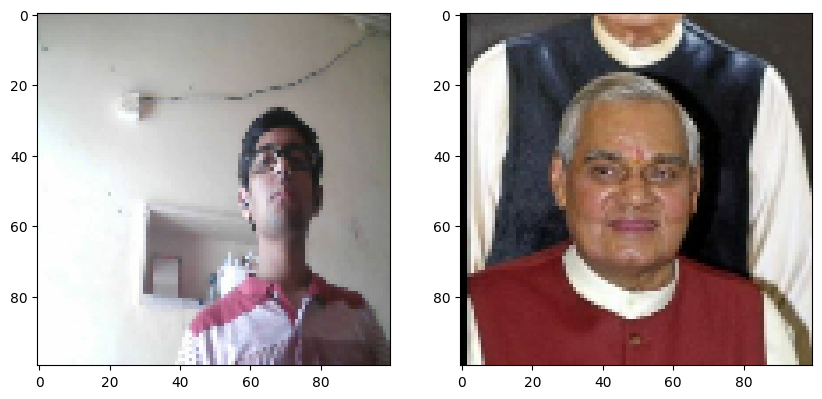

In [54]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()